<h2 align=center> Stock Market Anomaly detection</h2>


<h1 align=center> Détection d'anomalies dans les données de séries chronologiques choix : Keras</h1>

**Notre solution :**

     Concevoir et construire un auto-encodeur LSTM (Long short-term memory) à Keras
     Détecter les anomalies (changements de prix soudains) dans l'indice S&P 500
     Base de données : S&P 500 - 1986 - 2020

      **Le jeu de données est au format CSV avec :**

              1.   Horodatage quotidien
              2.   Prix d'ouverture et de fermeture quotidiens
              3.   Prix haut et bas quotidiens
              4.   Volume
          
* 1 : Aperçu du projet et bibliothèques d'importation
* 2 : Charger et inspecter les données de l'indice S&P 500
* 3 : Prétraitement des données
* 4 : Temporiser les données et créer des fractionnements d'entraînement et de test
* 5 : Construire un auto-encodeur LSTM
* 6 : Former l'auto-encodeur
* 7 : Tracer les métriques et évaluer le modèle
* 8 : Détecter les anomalies dans les données de l'indice S&P 500
* 9 : Visualiser les Anomalies en fonction du seuil


**Importation des fichiers**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/'My Drive'/Anomaly_stock_detection-master

/content/drive/My Drive/Anomaly_stock_detection-master


## Part 1: Importation des bibliothèques

In [3]:
#Bibliothèques nécessaires
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


## Part 2: Chargement et inspection de l'ensemble de données : S&P 500 Index Data

L'ensemble de données est une série chronologique avec un cours de clôture quotidien non ajusté pour l'indice S&P 500.

Le S&P 500 est un indicateur de performance boursière pour les 500 premières sociétés cotées en bourse aux États-Unis.

Il est considéré comme l'une des meilleures représentations du marché boursier américain.

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018 (Yahoo Finance)

In [4]:
#Convertion de la colonne Date au format au format de date pandas
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['Date'])

In [5]:
df = df.sort_values('Date')

In [6]:
#Visualisation du dataframe
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
3,1986-01-07,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
4,1986-01-08,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [7]:
#Nos interets se portent sur les colonnes Date et Close donc on laisse tomber le reste
df = df.drop(['Open', 'Adj Close', 'High', 'Volume', 'Low'], axis = 1) 
df.head() #Visualisation du dataframe

,Date,Close
0,1986-01-02,209.589996
1,1986-01-03,210.880005
2,1986-01-06,210.649994
3,1986-01-07,213.800003
4,1986-01-08,207.970001


In [8]:
#verification du nombre de lignes et de colonnes que contiennent dans le dataframe
df.shape

(8678, 2)

In [9]:
#Utilisons plotly pour tracer les données. Plotly nous permet de faire un graphique interactif.
fig = go.Figure() #Créer une figure vide
#add_trace pour ajouter des tracés à la figure
# #créer un graphique linéaire avec 'Close' comme légende, la colonne de Date comme axe des x et la colonne de Close comme axe des y.
fig.add_trace(go.Scatter(x = df.Date, y = df.Close, mode = 'lines', name = 'Close'))
fig.update_layout(showlegend = True, title='Plotting Close Price vs Date for the Dataset')

## Part 3: Prétraitement des données

In [10]:
train_size = int(len(df) * 0.8) #80% de la trame de données sera utilisée pour la formation
test_size = len(df) - train_size #20% de la trame de données sera utilisée pour les tests
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)] #Nous utilisons la méthode iloc pour spécifier le découpage par index
print(train.shape, test.shape) #Permet de voir la shape de donnees de train et de test.

(6942, 2) (1736, 2)


In [11]:
from sklearn.preprocessing import StandardScaler #Import StandardScaler pour normaliser les données de prix dans les données de formation   

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']]) #Nous utilisons StandardScaler pour apprendre les propriétés de la colonne Close en ajustant

train['Close'] = scaler.transform(train[['Close']]) #Transformation de la colonne 'Close' dans les données de train.
test['Close'] = scaler.transform(test[['Close']])  #transformation de la colonne 'Close' dans les données de test.

## Part 4: création des fractionnements d'entraînement et de test

In [12]:
#Nous devons temporaliser nos données
#Les réseaux LSTM nécessitent que les données d'entrée soient sous la forme de (n_échantillons x n_pas de temps x n_fonctionnalités)
#n_features = 1 et n_timesteps = 30 (jours)
#Ce processus doit être effectué sur X_train, y_train, X_test et y_test
#définir une fonction qui ferait le processus est efficace

def create_dataset(X, y, timesteps=1):
    Xs, ys = [], []
    for i in range(len(X) - timesteps): # boucle sur les données à l'aide de time_steps
        v = X.iloc[i:(i + timesteps)].values #Ajouter les valeurs de i à i+time_steps à la liste Xs
        Xs.append(v)        
        ys.append(y.iloc[i + timesteps]) #Ajouter de i à time_st|eps à la liste ys
    return np.array(Xs), np.array(ys) #Convertir les listes en tableaux numpy

In [13]:
time_steps = 30

X_train, y_train = create_dataset(train[['Close']], train.Close, time_steps)
X_test, y_test = create_dataset(test[['Close']], test.Close, time_steps)
# Vérifions les formes de notre répartition des données
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6912, 30, 1)
(6912,)
(1706, 30, 1)
(1706,)


## Part 5: Construction de l'auto-encodeur LSTM (LSTM Autoencoder)

1. Construire un réseau d'auto-encodeurs LSTM
2. Visualisez l'architecture du réseau et les flux de données

#### Pour obtenir un auto-encodeur pour détecter les anomalies
1. Entraîner l'auto-encodeur sur des données sans anomalies (données normales)
2. Prenez un point de données et reconstruisez-le et calculez l'erreur de reconstruction.
3. Si le point reconstruit a une erreur au-dessus d'un seuil assigné. Il est étiqueté comme une Anomalie.

In [14]:
#Réglage des paramètres
timesteps = X_train.shape[1] #30 dans X_train
num_features = X_train.shape[2] #nombre de caractéristiques est 1
print("Timesteps = ", timesteps)
print("NUmber of features = ", num_features)

Timesteps =  30
NUmber of features =  1


In [15]:
model = Sequential()
#Chaque entrée dans l'échantillon de données est un tableau 2D qui sera transmis à la couche réseau LSTM
#La sortie de la couche sera un vecteur de caractéristiques codé des données d'entrée

#La forme d'entrée est le timesteps d'un tableau 2D x n_features.
#La première couche aura 128 neurones
model.add(LSTM(units=128, input_shape=(timesteps, num_features)))

 #Régularisation du décrochage. 20% des neurones
model.add(Dropout(rate=0.2))

#Lorsque la deuxième couche cachée est LSTM :
#La sortie du vecteur de caractéristiques codé doit être répliquée * timesteps
model.add(RepeatVector(n=X_train.shape[1]))

#Couche de décodeur
#Nous définissons return_sequences sur True. Chaque neurone donnera un signal par timesteps
model.add(LSTM(units=128, return_sequences=True))

#Régularisation du décrochage
model.add(Dropout(rate=0.2))

#Pour utiliser TimeDistributedlayer, les séquences de retour de la couche LSTM précédente doivent être définies sur True
#C'est la couche de sortie. Il créera un vecteur avec la longueur des neurones LSTM précédents
model.add(TimeDistributed(Dense(units=X_train.shape[2])))  

#Compilation en utilisant l'erreur absolue moyenne comme fonction de perte
#Optimiseur 'Adam' pour descente de gradient avec taux d'apprentissage par défaut
model.compile(loss='mae', optimizer='adam')

#Voyons le résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

## Part 6: Entraînement de l'auto-encodeur

In [16]:
#Configurer un Early Stopper de formation pour suivre la perte de validation pour des améliorations
#Le stopper arrêtera l'entraînement lorsque la perte n'a pas diminué pendant 6 époques consécutives
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# Rappel du point de contrôle du modèle. Méthode utilisée pour enregistrer le meilleur modèle observé lors de l'entraînement.
mc = ModelCheckpoint('bestmodel.h5', monitor='val_loss', mode='min', save_best_only = True)

callback_list = [es, mc]

#Partage de validation des données du train à 10%.
#Shuffle défini sur False car l'ordre des données est important (données de séries chronologique)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks = callback_list,
    shuffle=False
)

Epoch 1/20
195/195 [==============================] - 20s 83ms/step - loss: 0.1672 - val_loss: 0.1524
Epoch 2/20
195/195 [==============================] - 15s 77ms/step - loss: 0.1078 - val_loss: 0.1033
Epoch 3/20
195/195 [==============================] - 15s 77ms/step - loss: 0.0921 - val_loss: 0.0706
Epoch 4/20
195/195 [==============================] - 15s 77ms/step - loss: 0.1041 - val_loss: 0.0646
Epoch 5/20
195/195 [==============================] - 15s 77ms/step - loss: 0.1028 - val_loss: 0.0827
Epoch 6/20
195/195 [==============================] - 15s 75ms/step - loss: 0.1119 - val_loss: 0.0942
Epoch 7/20
195/195 [==============================] - 15s 76ms/step - loss: 0.1217 - val_loss: 0.0954


## Part 7: Tracer les métriques et évaluer le modèle

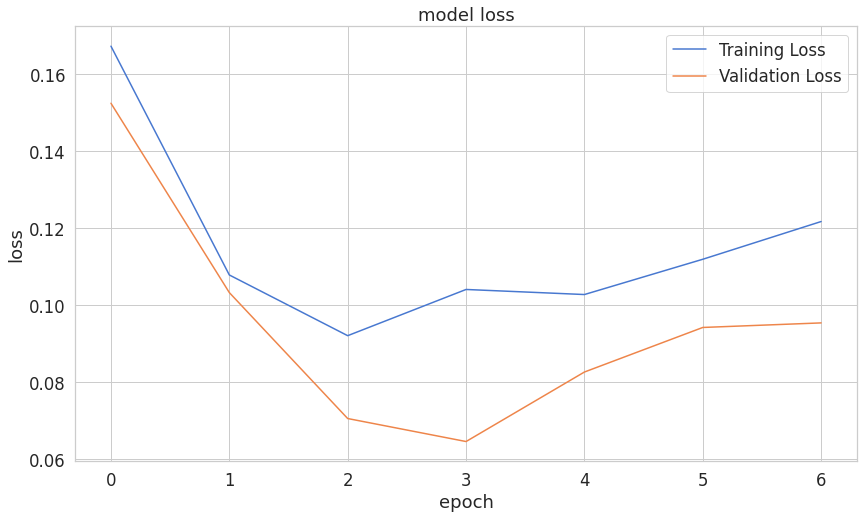

In [19]:
# Permet de tracer la formation et la perte de validation à l'aide de matplotlib
#Les valeurs de perte sont stockées dans history.history (dictionnaire)
plt.plot(history.history['loss'], label='Training Loss') #Plotting training loss
plt.plot(history.history['val_loss'], label='Validation Loss') #Plotting validation loss
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.legend(); #Utiliser des étiquettes comme légende

#Si la perte de validation est inférieure à la perte d'entraînement, cela signifie que le modèle est sous-ajusté.
#Si la perte de validation est supérieure à la perte d'entraînement, cela signifie que le modèle est surajusté

In [ ]:
X_train_pred = model.predict(X_train) #Modèle de prédiction sur les données d'entraînement
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [ ]:
#Évaluez le meilleur modèle sur les données de test pour la perte totale.
model.evaluate(X_test, y_test)

54/54 [==============================] - 1s 25ms/step - loss: 1.1578


1.1577861309051514

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



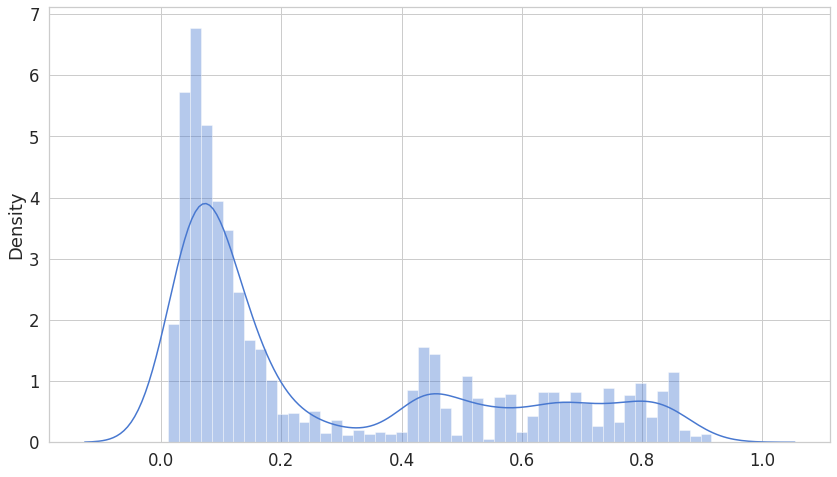

In [ ]:
# Permet de tracer le diagramme de distribution pour l'erreur de perte MAE à l'aide de seaborn
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
#Prédire X_test
X_test_pred = model.predict(X_test)
#Store MAE Loss pour les données de test
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



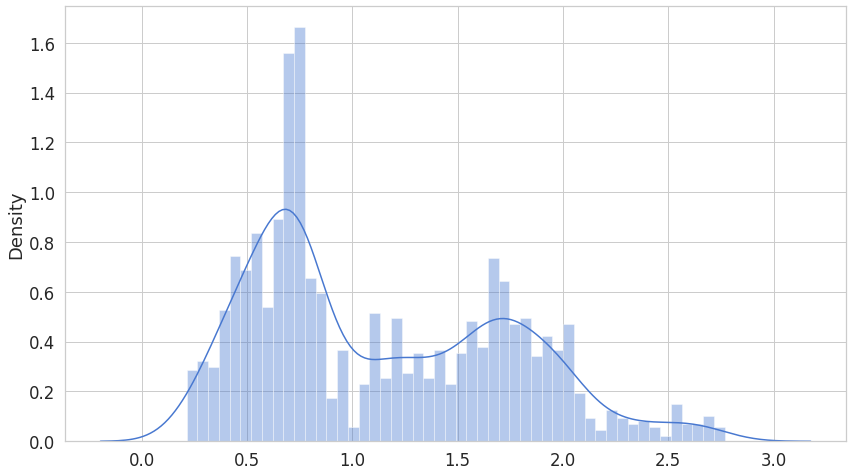

In [ ]:
# Permet de tracer le diagramme de distribution pour l'erreur de perte MAE à l'aide de seaborn
sns.distplot(test_mae_loss, bins=50, kde=True);

##  Part 8: **Prédire les anomalies sur les données de test en utilisant le seuil - Dataset S&P 500**

In [ ]:
# Permet de définir un seuil pour la perte MAE. Si l'erreur est plus grande, elle sera prédite comme une anomalie
THRESHOLD = 0.65 #Il s'agit de la valeur qui décide qu'un point de données est une anomalie ou non.
test_score_df = pd.DataFrame(test[time_steps:]) #Nous utilisons les données qui viennent après time_steps dans les données de test
#test_score_df = pd.DataFrame(index=test[time_steps:].index)
test_score_df['loss'] = test_mae_loss #Créer une colonne test_mae_loss
test_score_df['threshold'] = THRESHOLD #Créer une colonne de seuil 
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold #Définir l'anomalie sur Vrai si
test_score_df['Close'] = test[time_steps:].Close

In [ ]:
# Permet de créer un graphique interactif avec intrigue pour afficher les données avec des anomalies
fig = go.Figure() #graphe vide

#Créer un tracé linéaire avec l'axe des x comme valeurs après les pas de temps et l'axe des y comme valeurs de perte.
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))

#Créer un tracé linéaire avec l'axe des x comme valeurs après les pas de temps et l'axe des y comme seuil.
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
#Voyons le DataFrame nouvellement créé
test_score_df.head()

,Date,Close,loss,threshold,anomaly
6972,2013-08-27,1.758700,0.314828,0.65,False
6973,2013-08-28,1.769141,0.326663,0.65,False
6974,2013-08-29,1.776623,0.330003,0.65,False
6975,2013-08-30,1.764503,0.328202,0.65,False
6976,2013-09-03,1.780352,0.327839,0.65,False


In [ ]:
#Afficher les dernières entrées du dataframe
test_score_df.tail()

,Date,Close,loss,threshold,anomaly
8673,2020-06-01,5.080501,1.810746,0.65,True
8674,2020-06-02,5.138978,1.817022,0.65,True
8675,2020-06-03,5.236983,1.825285,0.65,True
8676,2020-06-04,5.212464,1.835593,0.65,True
8677,2020-06-05,5.402601,1.853322,0.65,True


In [ ]:
#Permet de créer un DataFrame pour toutes les Anomalies.
#Nous créons un DataFrame uniquement à partir des valeurs True dans la colonne Anomaly
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
7250,2014-10-03,2.545118,0.654104,0.65,True
7253,2014-10-08,2.547425,0.650503,0.65,True
7256,2014-10-13,2.327991,0.662564,0.65,True
7257,2014-10-14,2.334890,0.681763,0.65,True
7258,2014-10-15,2.299441,0.687353,0.65,True


In [ ]:
anomalies.shape

(1284, 5)

In [ ]:
test[time_steps:].Date

6972   2013-08-27
6973   2013-08-28
6974   2013-08-29
6975   2013-08-30
6976   2013-09-03
          ...    
8673   2020-06-01
8674   2020-06-02
8675   2020-06-03
8676   2020-06-04
8677   2020-06-05
Name: Date, Length: 1706, dtype: datetime64[ns]

In [34]:
test[time_steps:].Close

6972    1.758700
6973    1.769141
6974    1.776623
6975    1.764503
6976    1.780352
          ...   
8673    5.080501
8674    5.138978
8675    5.236983
8676    5.212464
8677    5.402601
Name: Close, Length: 1706, dtype: float64

In [35]:
print(anomalies.Close)

7250    2.545118
7253    2.547425
7256    2.327991
7257    2.334890
7258    2.299441
          ...   
8673    5.080501
8674    5.138978
8675    5.236983
8676    5.212464
8677    5.402601
Name: Close, Length: 1284, dtype: float64


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test['Date'],  mode ='lines', name='Close Price'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [ ]:
#Permet de créer un graphique interactif avec intrigue pour montrer les anomalies
fig = go.Figure()

#Nous devons inverser la transformation des prix de test en utilisant la méthode scalaire et le transformateur inverse intégré
#Créer un tracé linéaire avec l'axe des x comme valeurs de test après les pas de temps et l'axe des y comme cours de clôture.
fig.add_trace(go.Scatter(x=test['Date'], y=scaler.inverse_transform(test['Close']), 
                          mode ='lines', name='Close Price'))
#Créer un tracé linéaire avec l'axe des abscisses comme dates d'anomalie. l'axe des ordonnées comme prix d'anomalie.
#Nous utilisons mode = markers pour tracer un nuage de points
fig.add_trace(go.Scatter(x=anomalies.Date, y=scaler.inverse_transform(anomalies.Close),
                    mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()